# Heat Management of a "Building"

## Long Term Objective

Build a computational model of a hangar-type building with a flat roof of surface area $10\times 10\;\mathrm{m^2}$. The room's height is $5\;\mathrm{m}$. The target room temperature is $20^\circ\mathrm{C}$ throughout the year.

## This Week's Objective

Assuming that the building magically loses or gains heat through the roof only, and the inside surface of the roof is at constant temperature (target temperature), calculate the heat losses and gains throughout one year through convection heat transfer alone.

The roof is made of a $10\;\mathrm{cm}$ of concrete $k_{c}=0.17\;\mathrm{W/(K.m)}$ and $5\;\mathrm{cm}$ with $k_{i}=0.02\;\mathrm{W/(K.m)}$. The heat transfer in the roof is assumed to remain close to steady state throughout the fluctuations of outside weather, meaning that the thermal resistance approach can be used. 

Compare the heat rate with and without insulation in a graph.






In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as csts
from scipy.integrate import solve_ivp
from Libraries import thermodynamics as thermo
from Libraries import HT_external_convection as extconv
from Libraries import HT_natural_convection as natconv

In [2]:
xl = pd.ExcelFile('Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx')
weather = pd.read_excel("Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx",
                        sheet_name=xl.sheet_names[0],header=0,
                        converters= {'datetime': pd.to_datetime},)
weather = weather.set_index('datetime')
weather.head(10) 

,name,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,"Burlington, VT",-3.9,-7.7,-8.8,68.60,0.0,NaN,NaN,0.00,6.30,...,1030.1,48.8,16.0,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 01:00:00,"Burlington, VT",-3.4,-7.0,-8.8,65.95,0.0,NaN,NaN,0.00,6.29,...,1030.9,87.8,16.0,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 02:00:00,"Burlington, VT",-3.3,-6.5,-8.3,68.81,0.0,NaN,NaN,0.00,6.27,...,1031.9,100.0,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 03:00:00,"Burlington, VT",-2.9,-6.9,-8.2,66.44,0.0,NaN,NaN,0.00,6.26,...,1032.1,99.9,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 04:00:00,"Burlington, VT",-2.2,-5.1,-8.3,63.32,0.0,NaN,NaN,0.00,6.25,...,1032.4,99.9,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 05:00:00,"Burlington, VT",-2.2,-4.3,-8.3,63.22,0.0,NaN,NaN,0.00,6.24,...,1032.8,100.0,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 06:00:00,"Burlington, VT",-2.2,-5.7,-7.8,65.85,0.0,NaN,NaN,0.00,6.23,...,1032.9,100.0,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 07:00:00,"Burlington, VT",-2.2,-2.2,-7.8,65.80,0.0,NaN,NaN,0.00,6.22,...,1033.4,100.0,16.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."
2021-01-01 08:00:00,"Burlington, VT",-1.7,-1.7,-7.7,63.50,0.0,NaN,NaN,0.95,7.17,...,1033.5,100.0,16.0,3.0,0.0,0.0,NaN,Overcast,snow,"72622564776,ESXV1,KPBG,KBTV,KMVL,72611454771,7..."


In [3]:
interp_method = 'linear' 
weather['solarradiation'] = weather['solarradiation'].fillna(0.0)
weather['cloudcover'] = weather['cloudcover'].fillna(0.0)
weather['precip'] = weather['precip'].fillna(0.0)
weather['windspeed'] = weather['windspeed'].interpolate(interp_method)
weather['temp'] = weather['temp'].interpolate(interp_method)
weather['solarradiation'] = weather['solarradiation'].interpolate(interp_method)
weather['cloudcover'] = weather['cloudcover'].interpolate(interp_method)
weather['dew'] = weather['dew'].interpolate(interp_method)
weather['precip'] = weather['precip'].interpolate(interp_method)
weather['humidity'] = weather['humidity'].interpolate(interp_method)

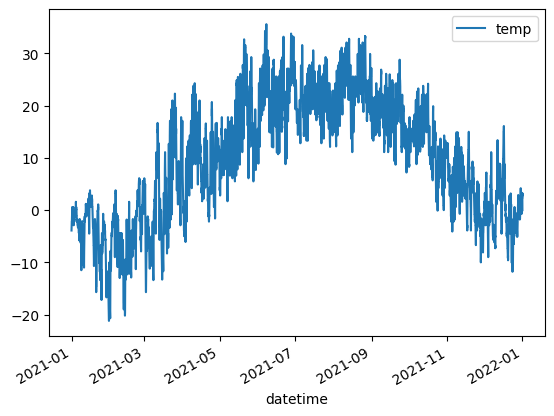

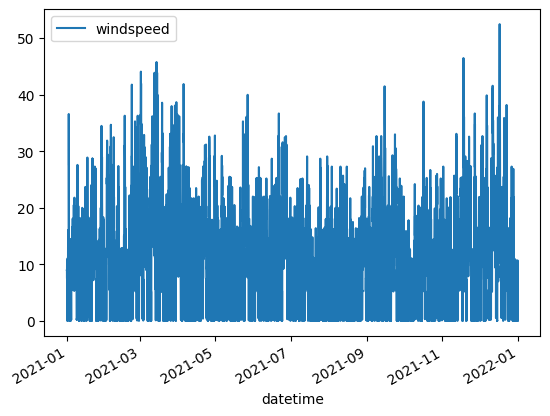

In [4]:
ax0 = weather.plot(y='temp')
ax0 = weather.plot(y='windspeed')

In [5]:
from scipy.interpolate import interp1d
interp_method = 'cubic'

t_data = np.arange(0,weather.shape[0]*15*60,15*60)
U_atm = np.abs(weather['windspeed'][:].to_numpy()/3.6) #converted from km/h to m/s
T_atm = weather['temp'][:].to_numpy()
q_sun = weather['solarradiation'][:].to_numpy()
# CC = weather['Cloud Cover'][:].to_numpy()
cc = weather['cloudcover'][:].to_numpy()/100. # converted from % to fraction
rh = weather['humidity'][:].to_numpy() # left as %
p_r = weather['precip'][:].to_numpy()*1e-3/(15*60) #converted to mm to m/s 
T_dp = weather['dew'][:].to_numpy()
f_U_atm = interp1d(t_data,U_atm,kind=interp_method)
def U_atmospheric(t):
    global f_U_atm
    return np.maximum(f_U_atm(t),0.)
f_T_atm = interp1d(t_data,T_atm,kind=interp_method)
def T_atmospheric(t):
    global f_T_atm
    return f_T_atm(t)
f_q_sun = interp1d(t_data,q_sun,kind=interp_method)
def sun_irradiation(t):
    global f_q_sun
    return np.maximum(f_q_sun(t),0.)
f_CC = interp1d(t_data,cc,kind=interp_method)
def cloud_cover(t):
    global f_CC
    return np.clip(f_CC(t),0.,1.)
f_T_dp = interp1d(t_data,T_dp,kind=interp_method)
def dew_point(t):
    global f_T_dp
    return f_T_dp(t)
f_RH = interp1d(t_data,rh,kind=interp_method)
def relative_humidity(t):
    global f_RH
    return np.clip(f_RH(t),0.,100.)
f_rain = interp1d(t_data,p_r,kind=interp_method)
def rain_rate(t):
    global f_rain
    return np.maximum(f_rain(t),0.)

#### Convection heat transfer on upper surface 

Convection heat transfer is determined by the relative strength of forced and natural convection. Here the forced convection is the wind over the roof. Regardless of the direction of the wind, the length of the slab is always assumed to be the dimension of the square making the roof $L$. Thermodynamics properties with a subscript $f$ denotes properties evaluated at the film temperature
$$
T_f = \frac{T_s+T_\infty}{2}\,,
$$ where $T_s$ is the temperature at the surface of the slab. For every time iteration, the following non-dimensional numbers are computed:
* Reynolds number quantifies the wind strength
$$
Re=\frac{U_\infty L}{\nu_f}
$$
* Grashoff number quantifies the natural convection strength
$$
Gr=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f^2}
$$
* Richardson number quantifies the relative strength of natural convection vs forced wind convection
$$
Ri=\frac{Gr}{Re^2}
$$
* Rayleigh number is required for Nusselt number convection in case of natural convection.
$$
Ra=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f\alpha_f}
$$

The following algorithm determines the local average convection coefficient
$$
\bar{h}=\bar{h}_{forced}+\bar{h}_{natural}=\frac{\overline{Nu}_{forced}k_f}{L}+\frac{\overline{Nu}_{natural}k_f}{L}
$$
where $\overline{Nu}_{forced}$ is the correlation for the flow over a plate at constant temperature and $\overline{Nu}_{natural}$ is the correlation for natural convection over a horizontal surface at constant temperature. 

* If the wind velocity drops below $U_\infty=0.15\mathrm{m/s}$, there is no forced convection: $h_{forced}=0$
* If $Ri<0.1$, natural convection is negligible, $h_{natural} = 0$, compute $h_{forced}$
* If $Ri>10$, forced convection is negligible, $h_{forced}=0$, compute $h_{natural}$
* If $0.1\leq Ri\leq 10$ compute both $h_{forced}$ and $h_{natural}$

In [6]:
L = 10 #m
H = 5 #m
A_roof = L**2 #m^2
h_concrete = 10e-2 #m
k_concrete = 0.17 #W/(m.K)
h_ins = 5e-2 #m
k_ins = 0.02 #W/(m.K)
T_room = 20. #C


### Equations

When assuming heat transfer to be driven by convection only, the conservation of energy at each interface dictates that the heat rate between the outside and the surface of the insulation $q_{conv}$, through the insulation $q_{ins}$ and through the concrete slab $q_{concrete}$ are equal to each other and to the total heat rate in or out of the room $q_{room}$.
$$
q_{conv}=q_{ins}=q_{concrete}=q_{room}\,.
$$

The roof is a plane wall, and the thermal resistances involved in the problem are
\begin{eqnarray}
R_{conv}&=&\frac{1}{hA}\\
R_{ins}&=&\frac{h_{ins}}{k_{ins}A}\\
R_{concrete}&=&\frac{h_{concrete}}{k_{concrete}A}
\end{eqnarray}

with heat rate defined as

\begin{eqnarray}
q_{conv}&=&\frac{1}{R_{conv}}(T_{s,o}-T_\infty)\\
q_{ins}&=&\frac{1}{R_{ins}}(T_{ins,conc}-T_{s,o})\\
q_{concrete}&=&\frac{1}{R_{concrete}}(T_{room}-T_{ins,conc})\\
q_{room}&=&\frac{1}{R_{total}}(T_{room}-T_\infty)
\end{eqnarray}

where $T_{ins,conc}$ is the temperature at the interface if insulation and concrete and $T_{room}=20^\circ\mathrm{C}$

### Thermal circuit


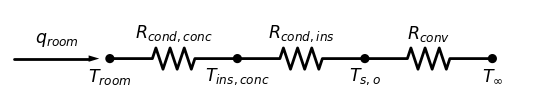

In [7]:
from Libraries import HT_thermal_resistance as res
import schemdraw as schem
import schemdraw.elements as elm

# Definition of Resistances

R = []
R.append(res.Resistance("$R_{cond,conc}$","W"))
R.append(res.Resistance("$R_{cond,ins}$","W"))
R.append(res.Resistance("$R_{conv}$","W"))

with schem.Drawing() as d:
    d += elm.Dot().label("$T_{room}$",'bottom')
    d += elm.Resistor().label(R[0].name)
    d += elm.Dot().label("$T_{ins,conc}$",'bottom')
    d += elm.Resistor().label(R[1].name)
    d += elm.Dot().label("$T_{s,o}$",'bottom')
    d += elm.Resistor().label(R[2].name)
    d += elm.Dot().label("$T_{\infty}$",'bottom')
    d += elm.Line(arrow='->').right().at((-2.25,0)).length(2).label("$q_{room}$")

### Roof modeling with insulation

Under 1D, quasi-steady approximations, the roof has a total resistance
$$
R_{roof}=R_{cond,conc}+R_{cond,ins}
$$


In [8]:
# Compute thermal resistances

# Concrete slab

R[0].cond_plane(k_concrete,h_concrete,A=A_roof)

# Insulation slab
R[1].cond_plane(k_ins,h_ins,A=A_roof)

R_roof = R[0].R + R[1].R
print("Thermal resistance of the concrete slab: %.4f K/W" %R[0].R)
print("Thermal resistance of the insulation slab: %.4f K/W" %R[1].R)
print("Thermal resistance of the roof (concrete+insulation): %.4f K/W" %R_roof)

Thermal resistance of the concrete slab: 0.0059 K/W
Thermal resistance of the insulation slab: 0.0250 K/W
Thermal resistance of the roof (concrete+insulation): 0.0309 K/W


### Convection

In [9]:
def h_convection(T_inf,T_s,U_inf,L):
    T_f = (T_s + T_inf)/2
    #air thermodynamic properties
    atmo_f = thermo.Fluid('air',T_f,"C")
    if (U_inf > 0.15):
        Re = U_inf*L / atmo_f.nu
    else:
        Re = 0.
        forced_convection = False
    Gr = natconv.Gr(beta=atmo_f.beta,DT=np.abs(T_s-T_inf),D=L,nu=atmo_f.nu)
    Ra = natconv.Ra(beta=atmo_f.beta,DT=np.abs(T_s-T_inf),D=L,nu=atmo_f.nu,alpha=atmo_f.alpha)
    
    if (Re > 0.):
        Ri = Gr/Re**2
        if (Ri < 0.1):
            forced_convection = True
            natural_convection = False
        elif (Ri >= 0.1) and (Ri <= 10.):
            forced_convection = True
            natural_convection = True
        else:
            forced_convection = False
            natural_convection = True
        if forced_convection:
            wind_convection = extconv.FlatPlate('mixed','isothermal',U_infty=U_inf,nu=atmo_f.nu,alpha=atmo_f.alpha, L=L, xi = 0,Re_xc=5e5)
            wind_convection.average(L)
            hconv_forced = wind_convection.Nu_ave*atmo_f.k/L
    else:
        hconv_forced = 0.
        natural_convection = True
    if natural_convection and (T_s != T_inf) and (Ra > 1.5e3):
        if T_s > T_inf:
            nat_convection = natconv.FlatPlate(Ra,atmo_f.Pr,'upper','hot')
        elif T_s < T_inf:
            nat_convection = natconv.FlatPlate(Ra,atmo_f.Pr,'upper','cold')
        hconv_natural = nat_convection.Nu*atmo_f.k/L
    else:
        hconv_natural = 0.
    hconv = 0.
    if forced_convection:
        hconv += hconv_forced
    if natural_convection:
        hconv += hconv_natural
# 
    if hconv == 0.:
        print("Re=%.2e, Gr=%.2e, hconv_forced=%.2f W/K, hconv_nat=%.2f W/K" %(Re,Gr,hconv_forced,hconv_natural))
        print(T_s,T_inf)
    return hconv,Re,Gr,Ra

In [10]:
weather.shape[0]

8760

In [11]:
def q_convection(R,Rroof):
    q_tot = np.zeros(weather.shape[0])
    T_so = np.zeros(weather.shape[0])
    for i in range(weather.shape[0]):

        T_inf = weather['temp'][i]
        U_inf = weather['windspeed'][i]
        if (T_room != T_inf):
#             if i == 0:
#                 #first guess for T_so
            T_s = (T_room + T_inf)/2
#             else:
#                 if (np.abs(T_so[i-1] - T_inf) > 1.):
#                     T_s = T_so[i-1]
#                 else:
#                     T_s = (T_room + T_inf)/2
            T_s_error = np.inf
            iter_error = 0
            Niter_error = 100
            while (T_s_error > 1e-1) and (iter_error < Niter_error) :
                T_s_old = T_s
                hconv,Re,Gr,Ra = h_convection(T_inf,T_s,U_inf,L)
#                 if (Re == 0.):
#                     print(i,iter_error,T_s,T_s_old)
                if (hconv == 0.):
                    print("problem")
                R[2].convection(h=hconv,A=A_roof)
                R_tot = Rroof + R[2].R
                qtot = (T_room - T_inf)/R_tot
            #     print(q_tot[i])
                # New T_so
                T_s = T_room - qtot*R_roof
                iter_error += 1
                T_s_error = np.abs(T_s - T_s_old)
#                 print(iter_error,T_s,T_s_old,T_inf)
#                 T_s = 0.7*T_s + 0.3*T_s_old
            if (iter_error == Niter_error):
                print("max iter",T_s,T_inf,T_s > T_inf)
                print("Re:%.2e, Ra:%.2e, Ri:%.2e"%(Re,Ra,Gr**2/Re))
            T_so[i] = T_s
            q_tot[i] = qtot

        else:
            T_so[i] = T_room
            q_tot[i] = 0.
    return T_so,q_tot
#     print(T_so,T_so_old)


In [14]:
heatrate = pd.DataFrame(index=weather.index)
T_so, q_tot = q_convection(R, R[0].R+R[1].R)
heatrate['T_so (concrete+insulation)'] = T_so
heatrate['q (concrete+insulation)'] = q_tot
T_so, q_tot = q_convection(R, R[0].R)
heatrate['T_so (concrete)'] = T_so
heatrate['q (concrete)'] = q_tot

max iter 16.28717792836344 14.8 True
Re:1.36e+05, Ra:9.05e+10, Ri:1.19e+17
max iter 16.28717792836344 14.8 True
Re:1.36e+05, Ra:9.05e+10, Ri:1.19e+17
max iter 14.750527343943677 12.8 True
Re:1.38e+05, Ra:1.30e+11, Ri:2.40e+17
max iter 15.77628693267069 14.2 True
Re:1.37e+05, Ra:1.02e+11, Ri:1.50e+17
max iter 14.677164384060955 12.7 True
Re:1.38e+05, Ra:1.32e+11, Ri:2.48e+17
max iter 7.400033598236508 4.3 True
Re:2.17e+05, Ra:3.27e+11, Ri:9.72e+17
max iter 7.157019862718668 4.0 True
Re:2.18e+05, Ra:3.35e+11, Ri:1.02e+18
max iter 15.117152923107396 13.3 True
Re:1.37e+05, Ra:1.20e+11, Ri:2.05e+17
max iter 8.856278080113492 6.1 True
Re:2.15e+05, Ra:2.81e+11, Ri:7.23e+17
max iter 14.677164384060955 12.7 True
Re:1.38e+05, Ra:1.32e+11, Ri:2.48e+17
max iter 14.677164384060955 12.7 True
Re:1.38e+05, Ra:1.32e+11, Ri:2.48e+17
max iter 15.190440254894387 13.4 True
Re:1.37e+05, Ra:1.18e+11, Ri:1.99e+17
max iter 15.849461397470584 14.3 True
Re:1.37e+05, Ra:1.00e+11, Ri:1.45e+17
max iter 15.556688462

/var/folders/hd/msvhbc550t13nl54x1ft6rgw0000gp/T/ipykernel_29268/951796143.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  print("Re:%.2e, Ra:%.2e, Ri:%.2e"%(Re,Ra,Gr**2/Re))


max iter 18.671918453013838 0.0 True
Re:4.15e+05, Ra:6.21e+12, Ri:1.82e+20
max iter 18.671918453013838 0.0 True
Re:2.49e+05, Ra:6.21e+12, Ri:3.04e+20
max iter 18.671918453013838 0.0 True
Re:4.15e+05, Ra:6.21e+12, Ri:1.82e+20
max iter 18.602446258149342 -1.2 True
Re:1.68e+05, Ra:6.81e+12, Ri:5.41e+20
max iter 18.602446258149342 -1.2 True
Re:0.00e+00, Ra:6.81e+12, Ri:inf
max iter 18.602446258149342 -1.2 True
Re:1.68e+05, Ra:6.81e+12, Ri:5.41e+20
max iter 18.551093012652917 -2.1 True
Re:5.10e+05, Ra:7.29e+12, Ri:2.04e+20
max iter 18.545426784907146 -2.2 True
Re:2.55e+05, Ra:7.34e+12, Ri:4.14e+20
max iter 18.573837281469935 -1.7 True
Re:0.00e+00, Ra:7.07e+12, Ri:inf
max iter 18.573837281469935 -1.7 True
Re:0.00e+00, Ra:7.07e+12, Ri:inf
max iter 18.573837281469935 -1.7 True
Re:0.00e+00, Ra:7.07e+12, Ri:inf
max iter 18.573837281469935 -1.7 True
Re:0.00e+00, Ra:7.07e+12, Ri:inf
max iter 18.573837281469935 -1.7 True
Re:0.00e+00, Ra:7.07e+12, Ri:inf
max iter 18.608191883636323 -1.1 True
Re:1.68

max iter 18.511595981986407 -2.8 True
Re:3.42e+05, Ra:7.68e+12, Ri:3.37e+20
max iter 18.511595981986407 -2.8 True
Re:0.00e+00, Ra:7.68e+12, Ri:inf
max iter 18.48362163946994 -3.3 True
Re:1.72e+05, Ra:7.96e+12, Ri:7.20e+20
max iter 18.511595981986407 -2.8 True
Re:0.00e+00, Ra:7.68e+12, Ri:inf
max iter 18.48362163946994 -3.3 True
Re:3.44e+05, Ra:7.96e+12, Ri:3.60e+20
max iter 18.450313806448285 -3.9 True
Re:0.00e+00, Ra:8.32e+12, Ri:inf
max iter 17.96074338716648 -13.4 True
Re:0.00e+00, Ra:1.57e+13, Ri:inf
max iter 17.932198216387615 -14.0 True
Re:1.97e+05, Ra:1.63e+13, Ri:2.60e+21
max iter 17.932198216387615 -14.0 True
Re:1.97e+05, Ra:1.63e+13, Ri:2.60e+21
max iter 17.780210246530913 -17.3 True
Re:0.00e+00, Ra:2.00e+13, Ri:inf
max iter 17.685086545311677 -19.5 True
Re:0.00e+00, Ra:2.28e+13, Ri:inf
max iter 17.660593794891454 -20.1 True
Re:0.00e+00, Ra:2.36e+13, Ri:inf
max iter 17.620466118441172 -21.1 True
Re:2.16e+05, Ra:2.51e+13, Ri:5.57e+21
max iter 17.61650098721809 -21.2 True
Re:0.

max iter 18.013806048424616 -12.3 True
Re:0.00e+00, Ra:1.46e+13, Ri:inf
max iter 17.9847456262457 -12.9 True
Re:0.00e+00, Ra:1.52e+13, Ri:inf
max iter 17.9847456262457 -12.9 True
Re:0.00e+00, Ra:1.52e+13, Ri:inf
max iter 18.013806048424616 -12.3 True
Re:0.00e+00, Ra:1.46e+13, Ri:inf
max iter 18.2147458112899 -8.3 True
Re:1.83e+05, Ra:1.13e+13, Ri:1.35e+21
max iter 18.325270947889962 -6.2 True
Re:0.00e+00, Ra:9.77e+12, Ri:inf
max iter 18.384552610530672 -5.1 True
Re:0.00e+00, Ra:9.05e+12, Ri:inf
max iter 18.352098751754983 -5.7 True
Re:1.77e+05, Ra:9.44e+12, Ri:9.82e+20
max iter 18.352098751754983 -5.7 True
Re:0.00e+00, Ra:9.44e+12, Ri:inf
max iter 18.325270947889962 -6.2 True
Re:1.78e+05, Ra:9.77e+12, Ri:1.05e+21
max iter 18.298640334493104 -6.7 True
Re:0.00e+00, Ra:1.01e+13, Ri:inf
max iter 18.303950688852165 -6.6 True
Re:1.79e+05, Ra:1.00e+13, Ri:1.10e+21
max iter 18.298640334493104 -6.7 True
Re:0.00e+00, Ra:1.01e+13, Ri:inf
max iter 18.298640334493104 -6.7 True
Re:0.00e+00, Ra:1.01e

max iter 19.788318779384298 17.1 True
Re:2.05e+05, Ra:5.55e+11, Ri:2.96e+18
max iter 19.624808486219194 14.8 True
Re:1.40e+05, Ra:1.06e+12, Ri:1.58e+19
max iter 18.887219051772373 3.6 True
Re:1.59e+05, Ra:4.60e+12, Ri:2.61e+20
max iter 18.760370531645194 1.5 True
Re:0.00e+00, Ra:5.50e+12, Ri:inf
max iter 18.701203326460014 0.5 True
Re:0.00e+00, Ra:5.96e+12, Ri:inf
max iter 18.596708577564886 -1.3 True
Re:0.00e+00, Ra:6.86e+12, Ri:inf
max iter 18.56813930830892 -1.8 True
Re:0.00e+00, Ra:7.13e+12, Ri:inf
max iter 18.56813930830892 -1.8 True
Re:0.00e+00, Ra:7.13e+12, Ri:inf
max iter 18.660260221417364 -0.2 True
Re:0.00e+00, Ra:6.30e+12, Ri:inf
max iter 18.893347366572364 3.7 True
Re:2.39e+05, Ra:4.56e+12, Ri:1.71e+20
max iter 19.145052232928258 7.7 True
Re:3.05e+05, Ra:3.08e+12, Ri:6.14e+19
max iter 18.83242404959948 2.7 True
Re:0.00e+00, Ra:4.97e+12, Ri:inf
max iter 18.62547644089741 -0.8 True
Re:0.00e+00, Ra:6.61e+12, Ri:inf
max iter 18.79025314657119 2.0 True
Re:0.00e+00, Ra:5.28e+12, 

max iter 18.579543193836166 -1.6 True
Re:1.69e+05, Ra:7.02e+12, Ri:5.72e+20
max iter 18.585257046547625 -1.5 True
Re:1.69e+05, Ra:6.97e+12, Ri:5.64e+20
max iter 18.585257046547625 -1.5 True
Re:2.53e+05, Ra:6.97e+12, Ri:3.76e+20
max iter 18.683608518802313 0.2 True
Re:1.65e+05, Ra:6.11e+12, Ri:4.43e+20
max iter 18.911780317716836 4.0 True
Re:2.38e+05, Ra:4.43e+12, Ri:1.63e+20
max iter 19.752327674575454 16.6 True
Re:2.75e+05, Ra:6.18e+11, Ri:2.75e+18
max iter 19.437782000097542 12.1 True
Re:0.00e+00, Ra:1.74e+12, Ri:inf
max iter 19.363105253193062 11.0 True
Re:0.00e+00, Ra:2.05e+12, Ri:inf
max iter 19.329451460869855 10.5 True
Re:0.00e+00, Ra:2.20e+12, Ri:inf
max iter 19.183916449200005 8.3 True
Re:0.00e+00, Ra:2.88e+12, Ri:inf
max iter 19.183916449200005 8.3 True
Re:0.00e+00, Ra:2.88e+12, Ri:inf
max iter 19.216524711888777 8.8 True
Re:0.00e+00, Ra:2.72e+12, Ri:inf
max iter 19.75960462461656 16.7 True
Re:2.06e+05, Ra:6.38e+11, Ri:3.90e+18
max iter 19.295978856314804 10.0 True
Re:1.49e+0

max iter 19.444614357132902 12.2 True
Re:0.00e+00, Ra:1.72e+12, Ri:inf
max iter 19.80271973536826 17.3 True
Re:1.36e+05, Ra:5.14e+11, Ri:3.82e+18
max iter 20.24495293357318 23.3 False
Re:2.63e+05, Ra:5.02e+11, Ri:1.89e+18
max iter 19.90434623716631 18.7 True
Re:0.00e+00, Ra:2.38e+11, Ri:inf
max iter 19.781129272535978 17.0 True
Re:0.00e+00, Ra:5.75e+11, Ri:inf
max iter 19.67416364382058 15.5 True
Re:0.00e+00, Ra:9.00e+11, Ri:inf
max iter 19.67416364382058 15.5 True
Re:0.00e+00, Ra:9.00e+11, Ri:inf
max iter 19.624808486219194 14.8 True
Re:0.00e+00, Ra:1.06e+12, Ri:inf
max iter 19.911660213213306 18.8 True
Re:0.00e+00, Ra:2.19e+11, Ri:inf
max iter 20.044250757778045 20.6 False
Re:1.34e+05, Ra:4.57e+11, Ri:3.08e+18
max iter 20.088129707154827 21.2 False
Re:1.35e+05, Ra:9.40e+11, Ri:1.29e+19
max iter 19.438876713585177 12.1 True
Re:3.64e+05, Ra:1.95e+12, Ri:2.06e+19
max iter 19.15150948287608 7.8 True
Re:0.00e+00, Ra:3.05e+12, Ri:inf
max iter 19.112886638480557 7.2 True
Re:2.30e+05, Ra:3.2

max iter 19.948331870908103 19.3 True
Re:0.00e+00, Ra:1.13e+11, Ri:inf
max iter 19.83863387478916 17.8 True
Re:2.03e+05, Ra:3.01e+11, Ri:8.78e+17
max iter 19.71675266590734 16.1 True
Re:2.07e+05, Ra:7.67e+11, Ri:5.60e+18
max iter 19.681243563832474 15.6 True
Re:2.09e+05, Ra:8.78e+11, Ri:7.29e+18
max iter 19.6318373426128 14.9 True
Re:0.00e+00, Ra:1.04e+12, Ri:inf
max iter 19.589773546216595 14.3 True
Re:0.00e+00, Ra:1.18e+12, Ri:inf
max iter 19.520249975037558 13.3 True
Re:0.00e+00, Ra:1.43e+12, Ri:inf
max iter 19.68833078264673 15.7 True
Re:1.39e+05, Ra:8.56e+11, Ri:1.04e+19
max iter 19.831609444349215 17.7 True
Re:0.00e+00, Ra:4.33e+11, Ri:inf
max iter 19.58278841959559 14.2 True
Re:0.00e+00, Ra:1.20e+12, Ri:inf
max iter 19.547972038240193 13.7 True
Re:0.00e+00, Ra:1.33e+12, Ri:inf
max iter 19.520249975037558 13.3 True
Re:1.43e+05, Ra:1.43e+12, Ri:2.82e+19
max iter 19.520249975037558 13.3 True
Re:0.00e+00, Ra:1.43e+12, Ri:inf
max iter 19.6318373426128 14.9 True
Re:0.00e+00, Ra:1.04e+

max iter 19.788318779384298 17.1 True
Re:0.00e+00, Ra:5.55e+11, Ri:inf
max iter 19.788318779384298 17.1 True
Re:1.37e+05, Ra:5.55e+11, Ri:4.44e+18
max iter 19.752444362864633 16.6 True
Re:0.00e+00, Ra:6.60e+11, Ri:inf
max iter 19.752444362864633 16.6 True
Re:0.00e+00, Ra:6.60e+11, Ri:inf
max iter 19.71675266590734 16.1 True
Re:0.00e+00, Ra:7.67e+11, Ri:inf
max iter 19.788318779384298 17.1 True
Re:1.37e+05, Ra:5.55e+11, Ri:4.44e+18
max iter 19.911662043246867 18.8 True
Re:1.34e+05, Ra:2.21e+11, Ri:7.16e+17
max iter 19.911660213213306 18.8 True
Re:0.00e+00, Ra:2.19e+11, Ri:inf
max iter 19.948331870908103 19.3 True
Re:0.00e+00, Ra:1.13e+11, Ri:inf
max iter 19.875163619672282 18.3 True
Re:1.35e+05, Ra:3.15e+11, Ri:1.45e+18
max iter 21.302507509587414 19.4 True
Re:2.00e+05, Ra:7.84e+10, Ri:6.07e+16
max iter 19.58278841959559 14.2 True
Re:0.00e+00, Ra:1.20e+12, Ri:inf
max iter 19.547972038240193 13.7 True
Re:0.00e+00, Ra:1.33e+12, Ri:inf
max iter 19.554920750955713 13.8 True
Re:2.13e+05, Ra:

max iter 19.437782000097542 12.1 True
Re:0.00e+00, Ra:1.74e+12, Ri:inf
max iter 19.6318373426128 14.9 True
Re:0.00e+00, Ra:1.04e+12, Ri:inf
max iter 19.58278841959559 14.2 True
Re:1.41e+05, Ra:1.20e+12, Ri:2.03e+19
max iter 19.554920750955713 13.8 True
Re:1.42e+05, Ra:1.30e+12, Ri:2.36e+19
max iter 19.520249975037558 13.3 True
Re:0.00e+00, Ra:1.43e+12, Ri:inf
max iter 19.485761092906326 12.8 True
Re:1.44e+05, Ra:1.56e+12, Ri:3.33e+19
max iter 19.71675266590734 16.1 True
Re:1.38e+05, Ra:7.67e+11, Ri:8.40e+18
max iter 19.681243563832474 15.6 True
Re:0.00e+00, Ra:8.78e+11, Ri:inf
max iter 19.681243563832474 15.6 True
Re:0.00e+00, Ra:8.78e+11, Ri:inf
max iter 19.681243563832474 15.6 True
Re:1.39e+05, Ra:8.78e+11, Ri:1.09e+19
max iter 19.363105253193062 11.0 True
Re:0.00e+00, Ra:2.05e+12, Ri:inf
max iter 19.216524711888777 8.8 True
Re:1.51e+05, Ra:2.72e+12, Ri:9.73e+19
max iter 19.157974779110955 7.9 True
Re:1.52e+05, Ra:3.02e+12, Ri:1.18e+20
max iter 19.112886638480557 7.2 True
Re:2.30e+05

max iter 19.911660213213306 18.8 True
Re:0.00e+00, Ra:2.19e+11, Ri:inf
max iter 19.948331870908103 19.3 True
Re:0.00e+00, Ra:1.13e+11, Ri:inf
max iter 19.911660213213306 18.8 True
Re:0.00e+00, Ra:2.19e+11, Ri:inf
max iter 19.911660213213306 18.8 True
Re:0.00e+00, Ra:2.19e+11, Ri:inf
max iter 19.875163619672282 18.3 True
Re:0.00e+00, Ra:3.15e+11, Ri:inf
max iter 19.83885016844088 17.8 True
Re:0.00e+00, Ra:4.13e+11, Ri:inf
max iter 19.795515599996577 17.2 True
Re:0.00e+00, Ra:5.34e+11, Ri:inf
max iter 19.795515599996577 17.2 True
Re:0.00e+00, Ra:5.34e+11, Ri:inf
max iter 19.788318779384298 17.1 True
Re:0.00e+00, Ra:5.55e+11, Ri:inf
max iter 19.71675266590734 16.1 True
Re:0.00e+00, Ra:7.67e+11, Ri:inf
max iter 19.485761092906326 12.8 True
Re:2.16e+05, Ra:1.56e+12, Ri:2.22e+19
max iter 19.295978856314804 10.0 True
Re:0.00e+00, Ra:2.35e+12, Ri:inf
max iter 19.249421364320757 9.3 True
Re:0.00e+00, Ra:2.57e+12, Ri:inf
max iter 19.216524711888777 8.8 True
Re:0.00e+00, Ra:2.72e+12, Ri:inf
max i

max iter 18.602446258149342 -1.2 True
Re:1.68e+05, Ra:6.81e+12, Ri:5.41e+20
max iter 18.573837281469935 -1.7 True
Re:1.69e+05, Ra:7.07e+12, Ri:5.80e+20
max iter 18.573837281469935 -1.7 True
Re:2.54e+05, Ra:7.07e+12, Ri:3.87e+20
max iter 18.545426784907146 -2.2 True
Re:0.00e+00, Ra:7.34e+12, Ri:inf
max iter 18.56813930830892 -1.8 True
Re:0.00e+00, Ra:7.13e+12, Ri:inf
max iter 18.73068730544416 1.0 True
Re:0.00e+00, Ra:5.73e+12, Ri:inf
max iter 18.701203326460014 0.5 True
Re:0.00e+00, Ra:5.96e+12, Ri:inf
max iter 18.666085358509374 -0.1 True
Re:2.49e+05, Ra:6.26e+12, Ri:3.08e+20
max iter 18.666085358509374 -0.1 True
Re:0.00e+00, Ra:6.26e+12, Ri:inf
max iter 18.666085358509374 -0.1 True
Re:0.00e+00, Ra:6.26e+12, Ri:inf
max iter 18.602446258149342 -1.2 True
Re:0.00e+00, Ra:6.81e+12, Ri:inf
max iter 18.56813930830892 -1.8 True
Re:1.69e+05, Ra:7.13e+12, Ri:5.88e+20
max iter 18.596708577564886 -1.3 True
Re:0.00e+00, Ra:6.86e+12, Ri:inf
max iter 18.56813930830892 -1.8 True
Re:0.00e+00, Ra:7.13

max iter 18.2147458112899 -8.3 True
Re:0.00e+00, Ra:1.13e+13, Ri:inf
max iter 18.194086899796996 -8.7 True
Re:0.00e+00, Ra:1.16e+13, Ri:inf
max iter 18.579543193836166 -1.6 True
Re:2.53e+05, Ra:7.02e+12, Ri:3.81e+20
max iter 18.573837281469935 -1.7 True
Re:1.69e+05, Ra:7.07e+12, Ri:5.80e+20
max iter 18.545426784907146 -2.2 True
Re:1.70e+05, Ra:7.34e+12, Ri:6.21e+20
max iter 18.545426784907146 -2.2 True
Re:0.00e+00, Ra:7.34e+12, Ri:inf
max iter 18.545426784907146 -2.2 True
Re:0.00e+00, Ra:7.34e+12, Ri:inf
max iter 18.545426784907146 -2.2 True
Re:1.70e+05, Ra:7.34e+12, Ri:6.21e+20
max iter 18.511595981986407 -2.8 True
Re:2.57e+05, Ra:7.68e+12, Ri:4.49e+20
max iter 18.455845320129807 -3.8 True
Re:1.73e+05, Ra:8.26e+12, Ri:7.69e+20
max iter 18.395433753436258 -4.9 True
Re:0.00e+00, Ra:8.93e+12, Ri:inf
max iter 18.395433753436258 -4.9 True
Re:1.75e+05, Ra:8.93e+12, Ri:8.87e+20
max iter 18.303950688852165 -6.6 True
Re:4.48e+05, Ra:1.00e+13, Ri:4.39e+20
max iter 18.325270947889962 -6.2 True
R

max iter 18.671918453013838 0.0 True
Re:0.00e+00, Ra:6.21e+12, Ri:inf


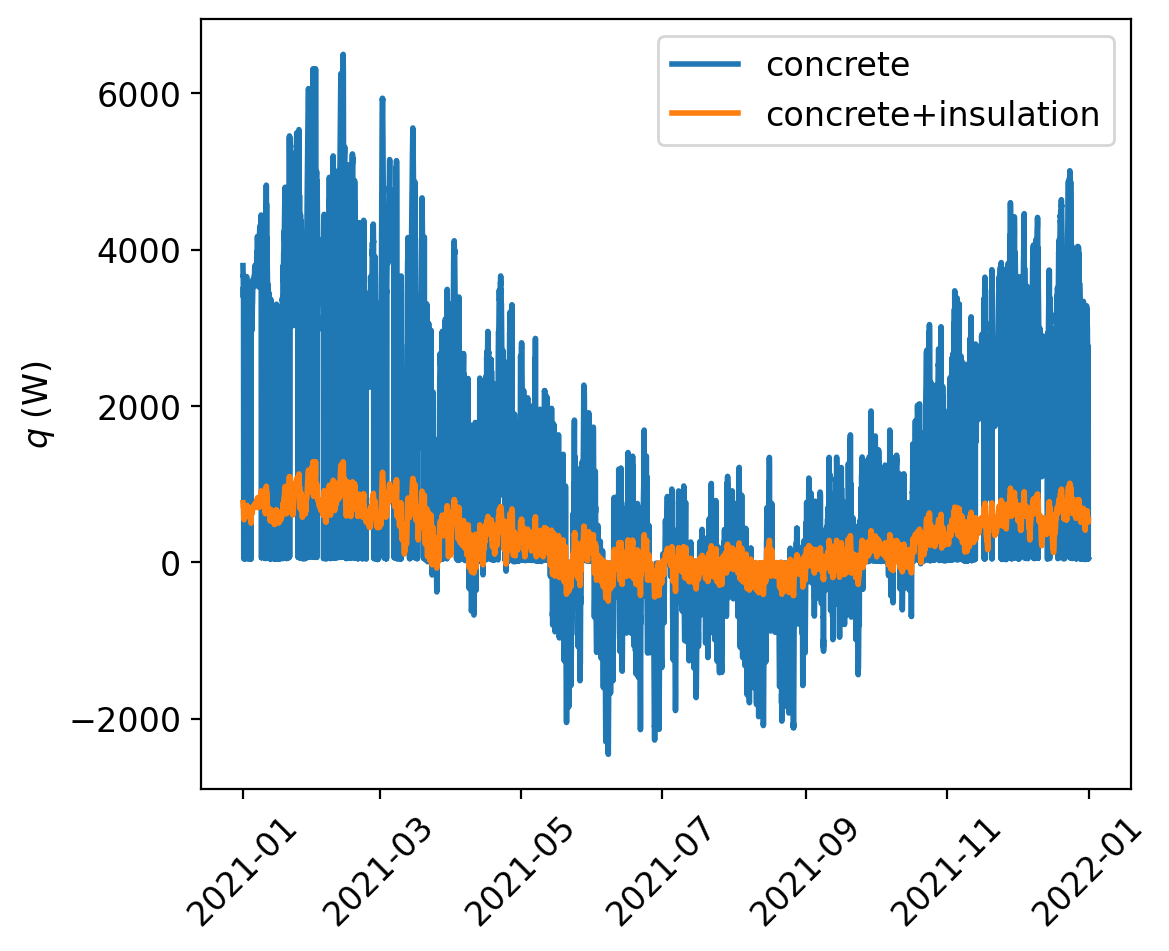

In [15]:
# Convection resistance q_conv=hA(T_s,o - T_inf)=(1/R_conv)(T_s,o - T_inf)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5),dpi=200,linewidth=4.0)
plt.plot(heatrate['q (concrete)'],linewidth=2.0, label="concrete")
plt.plot(heatrate['q (concrete+insulation)'],linewidth=2.0, label="concrete+insulation")

# ax0 = heatrate.plot(y='q (concrete+insulation)')
# heatrate.plot(ax=ax0, y='q (concrete)')
plt.ylabel("$q\;(\mathrm{W})$")
plt.xticks(rotation=45)
plt.legend()
plt.xlabel("")
plt.show()


In [ ]:
# Convection resistance q_conv=hA(T_s,o - T_inf)=(1/R_conv)(T_s,o - T_inf)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5),dpi=200,linewidth=4.0)
plt.plot(heatrate['T_so (concrete)'],linewidth=2.0, label="$T_{so}$ concrete")
plt.plot(heatrate['T_so (concrete+insulation)'],linewidth=2.0, label="$T_{so}$ concrete+insulation")
plt.plot(weather['temp'],linewidth=1.0, label="$T_\infty$")
# ax0 = heatrate.plot(y='q (concrete+insulation)')
# heatrate.plot(ax=ax0, y='q (concrete)')
plt.ylabel("$T_s\;(^\circ\mathrm{C})$")
plt.xticks(rotation=45)
plt.legend()
plt.xlabel("")
plt.show()


ax0 = heatrate.plot(y='T_so (concrete+insulation)')
heatrate.plot(ax=ax0, y='T_so (concrete)')